## Constructing machine learning potential

In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

--2020-09-29 02:18:17--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1601338757&Signature=n%2B%2FBV7Tn17SCCiuM%2B4vyOgX9fmY%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-09-29 02:18:17--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1601338757&Signature=n%2B%2FBV7Tn17SCCiuM

In [2]:
import sys
sys.path.insert(0, '../')
import numpy as np
import ase.io
import tqdm
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized
from nice.utilities import make_structural_features
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:10000"    #input for ase.io.read command
test_subset = "10000:15000"     #input to ase.io.read command
environments_for_fitting = 1000    #number of environments to fit nice transfomers
grid =  [150, 200, 350, 500, 750, 1000,
         1500, 2000, 3000, 5000, 7500, 10000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}

In [4]:
#our model:
def get_transformer():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                             StandardBlock(ThresholdExpansioner(num_expand = 150),
                                              CovariantsPurifierBoth(max_take = 10),
                                                  IndividualLambdaPCAsBoth(n_components = 50),
                                                 ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                                 InvariantsPurifier(max_take = 50),
                                                  InvariantsPCA(n_components = 200)),
                            StandardBlock(None,
                                             None,
                                                  None,
                                                  ThresholdExpansioner(num_expand =300, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 50),
                                                 InvariantsPCA(n_components = 200))
                                   ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True)
                          )

In [5]:
train_structures = ase.io.read('methane.extxyz', 
                         index = train_subset)


train_coefficients = get_rascal_coefficients_parallelized(train_structures, HYPERS)

test_structures = ase.io.read('methane.extxyz', 
                         index = test_subset)

test_coefficients = get_rascal_coefficients_parallelized(test_structures, HYPERS)

100%|██████████| 2/2 [00:00<00:00, 92.62it/s]


In [6]:
all_species = []
for structure in train_structures:
    all_species.append(np.array(structure.get_atomic_numbers()))
all_species = np.concatenate(all_species, axis=0)
all_species = np.sort(np.unique(all_species))


In [7]:
#individual transformers for each atomic specie in dataset
transformers = {}
for key in train_coefficients.keys():
    transformers[key] = get_transformer()

In [8]:
for key in train_coefficients.keys():
    transformers[key].fit(train_coefficients[key][:environments_for_fitting])

../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
../nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments

In [9]:
train_features = {}
for specie in all_species:
    train_features[specie] = transformers[specie].transform(train_coefficients[specie],
                                                            return_only_invariants = True)
    
test_features = {}
for specie in all_species:
    test_features[specie] = transformers[specie].transform(test_coefficients[specie],
                                                           return_only_invariants = True)

In [10]:
train_features = make_structural_features(train_features, train_structures)
test_features = make_structural_features(test_features, test_structures)

100%|██████████| 5000/5000 [00:00<00:00, 8348.81it/s]


In [11]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV


In [12]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))

def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values)) ** 2))

def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)

def estimate_performance(clf, data_train, data_test, targets_train, targets_test):
    clf.fit(data_train, targets_train)
    return get_relative_performance(clf.predict(data_test), targets_test)

In [13]:
errors = []
for el in tqdm.tqdm(grid):   
    errors.append(estimate_performance(BayesianRidge(), train_features[:el],
                                       test_features, train_energies[:el],
                                       test_energies))

100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


In [14]:
print(errors)

[0.42475707682463026, 0.4279185376733464, 0.3492008266166807, 0.23186154623365574, 0.18099637715376907, 0.1627617360623108, 0.13117557751441186, 0.1164749070161693, 0.09898349078930455, 0.08364100338420387, 0.07238494336948237, 0.06996193035290897]


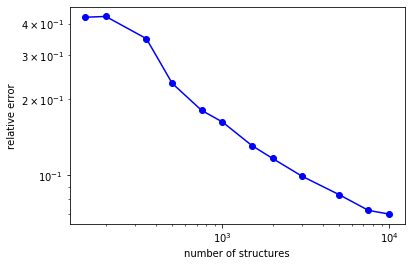

In [15]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()